# Data preparation for ASR

## Raw data

The raw data was fetched from Jonathan D. Amith (JDA)'s server via SFTP on Friday June 13, 2025. The main data used were sourced from the following folders:

```
# Sound files
html/mixtec/Sonidos/Yoloxochitl/

# ELAN .eaf transcriptions
html/mixtec/Transcripciones-AA-Active_2025-02/BotFl/
html/mixtec/Transcripciones-AA-Active_2025-02/Finalized/
html/mixtec/Transcripciones-AA-Active_2025-02/Not-translated
```

## Exploration

- Opening up a representative file `Yolox_Agric_EGS505_Siembra-de-frijoles_2010-12-15-t_ed-2025-02-12.eaf`, we can see that the transcriptions are on the tiers with `SURFACE` in the name.
- The audio is stereo with individually mic-ed participants and (thankfully consistent) is that the first `SURFACE` tier is associated with the first/left channel audio and the second tier with the right/second channel.

![](assets/mixtec-eaf-wav.png)

## Process one file

Let's write some helper functions to get the information out of one .eaf file (and hopefully we can straightforwardly apply it to all files; fingers crossed).

### Process annotations

In [1]:
eaf_file = "data/Transcripciones-AA-Active_2025-02/Finalized/Agricultura-Finalizados/Yolox_Agric_EGS505_Siembra-de-frijoles_2010-12-15-t_ed-2025-02-12.eaf"

In [2]:
from pympi.Elan import Eaf

eaf_data = Eaf(eaf_file)

In [3]:
def get_surface_tiers(eaf_data):
    # See https://dopefishh.github.io/pympi/Elan.html#pympi.Elan.Eaf, where tiers (dict) is
    # Tiers, where every tier is of the form: {tier_name -> (aligned_annotations, reference_annotations, attributes, ordinal)},
    return [ 
        tier_name for
        (tier_name, (aligned_annotations, reference_annotations, attributes, ordinal)) in 
        eaf_data.tiers.items() if attributes['LINGUISTIC_TYPE_REF'] == 'Surface' or
        'surface' in tier_name.lower()
    ]

In [4]:
surface_tiers = get_surface_tiers(eaf_data)

surface_tiers

['Esteban Guadalupe Sierra SURFACE2', 'Rey Castillo García SURFACE2']

In [5]:
import pandas as pd

def get_surface_tier_annotations(tier_name, eaf_data):
    return pd.DataFrame([  
        {
            "tier" : tier_name,
            "annotation" : tier_data[2],
            "start_s" : round(tier_data[0]/1_000, 2),
            "duration_s" : round((tier_data[1] - tier_data[0])/1_000, 2)
        } for
        tier_data in
        eaf_data.get_annotation_data_for_tier(tier_name)
    ])

In [38]:
surface_tier_annotations = pd.concat([ get_surface_tier_annotations(t, eaf_data) for t in surface_tiers ])

surface_tier_annotations

,tier,annotation,start_s,duration_s
0,Esteban Guadalupe Sierra SURFACE2,ya¹ xa'¹a⁴ ndu³chi⁴ ndi⁴ u¹nĩ¹ chi⁴chi³ kwi³i³...,15.41,8.97
1,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ tu⁴u²⁴ ka⁴chyo²⁴ rã⁴,24.37,2.90
2,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ kwi³i³ chye'³e⁴² yu³mĩ...,27.27,3.00
3,Esteban Guadalupe Sierra SURFACE2,ya¹ ke'⁴e²⁴ jĩ'⁴ĩ⁴ ku⁴u⁴ ya¹ sa⁴bi⁴ kã⁴ ndi⁴,30.27,2.56
4,Esteban Guadalupe Sierra SURFACE2,"o⁴ra² xa¹⁴³ ji⁴tu³nã², o⁴ra² chi'³i³nã² i³tu² ...",32.83,5.74
...,...,...,...,...
16,Rey Castillo García SURFACE2,Ndi³chi² tyu⁴kũ⁴.,886.88,9.96
17,Rey Castillo García SURFACE2,"Mm, tã³ ba'¹a³nĩ⁴² ja⁴xi²⁴ ndi³ki'⁴ndya⁴³.",913.71,3.62
18,Rey Castillo García SURFACE2,¿Sa¹a³ nã³nỹũ⁴?,917.33,7.39
19,Rey Castillo García SURFACE2,¿Sa¹a³ kwi¹ỹõ⁴?,924.72,2.57


### Process audio

Since the `eaf_data.media_descriptors[0]['MEDIA_URL']` contains the absolute path on JDA's computer, we'll need to make a lookup table to resolve the paths to the local audio files contained within `/workspace/data/Yoloxochitl`

In [7]:
eaf_data.media_descriptors[0]['MEDIA_URL']

'file:///C:/Users/Kenia/Documents/JDA_MAYO_2021_11-16/GRABACIONES YOLO/Agricultura/Yolox_Agric_EGS505_Siembra-de-frijoles_2010-12-15-t.wav'

In [8]:
from pathlib import Path

wav_files_lookup = dict([ (wav_path.name, wav_path) for wav_path in Path("/workspace/data/Yoloxochitl/").glob("**/*.wav") ])

dict(list(wav_files_lookup.items())[:5])

{'Yolox_Botan_ECG503-CTB501_Acanthaceae-i3ta2-nde3e4-i14ni3_2013-07-06-b.wav': PosixPath('/workspace/data/Yoloxochitl/Botanica/Yolox_Botan_ECG503-CTB501_Acanthaceae-i3ta2-nde3e4-i14ni3_2013-07-06-b.wav'),
 'Yolox_Botan_ECG503-CTB501_Acanthaceae-i3ta2-kwi3in4_2013-07-06-c.wav': PosixPath('/workspace/data/Yoloxochitl/Botanica/Yolox_Botan_ECG503-CTB501_Acanthaceae-i3ta2-kwi3in4_2013-07-06-c.wav'),
 'Yolox_Botan_CTB501-FNL520_Zingiberaceae-i3ta2-pa3lo4ma2_2015-05-24-c.wav': PosixPath('/workspace/data/Yoloxochitl/Botanica/Yolox_Botan_CTB501-FNL520_Zingiberaceae-i3ta2-pa3lo4ma2_2015-05-24-c.wav'),
 'Yolox_Botan_CTB501-EGS505_Solanaceae-tun4-yu1ku1-ya4a24-ji1ndi1ki4_2015-05-30-c.wav': PosixPath('/workspace/data/Yoloxochitl/Botanica/Yolox_Botan_CTB501-EGS505_Solanaceae-tun4-yu1ku1-ya4a24-ji1ndi1ki4_2015-05-30-c.wav'),
 'Yolox_Botan_ECG503-CTB510_Asteraceae-i3ta2-kwa4an2_2013-07-08-e.wav': PosixPath('/workspace/data/Yoloxochitl/Botanica/Yolox_Botan_ECG503-CTB510_Asteraceae-i3ta2-kwa4an2_2013-07

In [9]:
def get_local_wav_file_path(eaf_data, eaf_file):
    # Try finding the linked wav file according to the Eaf file first
    linked_wav_file_name = Path(eaf_data.media_descriptors[0]['MEDIA_URL']).name

    if linked_wav_file_name in wav_files_lookup:
        return wav_files_lookup[ linked_wav_file_name ]

    # Then try finding a wav file that has the same stem
    # eaf file with last edited date:           Yolox_Agric_MFG512_Testimonial-La-vida-de-un-campesino_2012-03-01-h_ed-2025-02-12.eaf
    # wav file with same stem (no edited date): Yolox_Agric_MFG512_Testimonial-La-vida-de-un-campesino_2012-03-01-h.wav
    wav_file_with_shared_stem_no_ed = Path(eaf_file).name.split('_ed')[0] + ".wav"

    if wav_file_with_shared_stem_no_ed in wav_files_lookup:
        return wav_files_lookup[ wav_file_with_shared_stem_no_ed ]
    else:
        # Return None if no corresponding wav file found
        return None

In [10]:
wav_file_path = get_local_wav_file_path(eaf_data, eaf_file)

wav_file_path

PosixPath('/workspace/data/Yoloxochitl/Agricultura/Yolox_Agric_EGS505_Siembra-de-frijoles_2010-12-15-t.wav')

If stereo audio, associate first tier with channel 0 (left) and second tier with channel 1 (right)

In [30]:
import torchaudio

def get_num_channels(wav_file_path):
    return torchaudio.info(wav_file_path).num_channels

In [31]:
get_num_channels(wav_file_path)

2

In [36]:
tier_channel_mappings = pd.DataFrame({
    "tier" : surface_tiers,
    "channel" : range(len(surface_tiers))
})

tier_channel_mappings

,tier,channel
0,Esteban Guadalupe Sierra SURFACE2,0
1,Rey Castillo García SURFACE2,1


In [39]:
surface_tier_annotations.merge(tier_channel_mappings, how='left')

,tier,annotation,start_s,duration_s,channel
0,Esteban Guadalupe Sierra SURFACE2,ya¹ xa'¹a⁴ ndu³chi⁴ ndi⁴ u¹nĩ¹ chi⁴chi³ kwi³i³...,15.41,8.97,0
1,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ tu⁴u²⁴ ka⁴chyo²⁴ rã⁴,24.37,2.90,0
2,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ kwi³i³ chye'³e⁴² yu³mĩ...,27.27,3.00,0
3,Esteban Guadalupe Sierra SURFACE2,ya¹ ke'⁴e²⁴ jĩ'⁴ĩ⁴ ku⁴u⁴ ya¹ sa⁴bi⁴ kã⁴ ndi⁴,30.27,2.56,0
4,Esteban Guadalupe Sierra SURFACE2,"o⁴ra² xa¹⁴³ ji⁴tu³nã², o⁴ra² chi'³i³nã² i³tu² ...",32.83,5.74,0
...,...,...,...,...,...
169,Rey Castillo García SURFACE2,Ndi³chi² tyu⁴kũ⁴.,886.88,9.96,1
170,Rey Castillo García SURFACE2,"Mm, tã³ ba'¹a³nĩ⁴² ja⁴xi²⁴ ndi³ki'⁴ndya⁴³.",913.71,3.62,1
171,Rey Castillo García SURFACE2,¿Sa¹a³ nã³nỹũ⁴?,917.33,7.39,1
172,Rey Castillo García SURFACE2,¿Sa¹a³ kwi¹ỹõ⁴?,924.72,2.57,1


In [50]:
def process_one_file(eaf_file):

    eaf_data = Eaf(eaf_file)

    wav_file_path = get_local_wav_file_path(eaf_data, eaf_file)

    if wav_file_path is None:
        # Skip file if no corresponding wav file found
        # Thankfully only ~16 out of 950 files
        return None

    audio_num_channels = get_num_channels(wav_file_path)
    surface_tiers = get_surface_tiers(eaf_data)

    if len(surface_tiers) == 0 or (len(surface_tiers) > 2 and audio_num_channels != 1):
        # Skip if no SURFACE tier found (also very few)
        # Skip if more than 2 SURFACE tiers and stereo channel (ambiguous tier-to-channel mapping; also very few)
        return None

    surface_tier_annotations = pd.concat([ get_surface_tier_annotations(t, eaf_data) for t in surface_tiers ])

    if audio_num_channels == 1:
        surface_tier_annotations["channel"] = 0 # Single channel audio, everything is on channel 0
    else:
        tier_channel_mappings = pd.DataFrame({ "tier" : surface_tiers, "channel" : range(len(surface_tiers)) })
        surface_tier_annotations = surface_tier_annotations.merge(tier_channel_mappings, how='left')
    
    surface_tier_annotations["wav_file"] = wav_file_path
    surface_tier_annotations["eaf_file"] = eaf_file
    
    return surface_tier_annotations

In [51]:
process_one_file("data/Transcripciones-AA-Active_2025-02/Finalized/Agricultura-Finalizados/Yolox_Agric_EGS505_Siembra-de-frijoles_2010-12-15-t_ed-2025-02-12.eaf")

,tier,annotation,start_s,duration_s,channel,wav_file,eaf_file
0,Esteban Guadalupe Sierra SURFACE2,ya¹ xa'¹a⁴ ndu³chi⁴ ndi⁴ u¹nĩ¹ chi⁴chi³ kwi³i³...,15.41,8.97,0,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
1,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ tu⁴u²⁴ ka⁴chyo²⁴ rã⁴,24.37,2.90,0,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
2,Esteban Guadalupe Sierra SURFACE2,i³kã⁴ i⁴yo² tu³kwa² ya¹ kwi³i³ chye'³e⁴² yu³mĩ...,27.27,3.00,0,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
3,Esteban Guadalupe Sierra SURFACE2,ya¹ ke'⁴e²⁴ jĩ'⁴ĩ⁴ ku⁴u⁴ ya¹ sa⁴bi⁴ kã⁴ ndi⁴,30.27,2.56,0,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
4,Esteban Guadalupe Sierra SURFACE2,"o⁴ra² xa¹⁴³ ji⁴tu³nã², o⁴ra² chi'³i³nã² i³tu² ...",32.83,5.74,0,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
...,...,...,...,...,...,...,...
169,Rey Castillo García SURFACE2,Ndi³chi² tyu⁴kũ⁴.,886.88,9.96,1,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
170,Rey Castillo García SURFACE2,"Mm, tã³ ba'¹a³nĩ⁴² ja⁴xi²⁴ ndi³ki'⁴ndya⁴³.",913.71,3.62,1,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
171,Rey Castillo García SURFACE2,¿Sa¹a³ nã³nỹũ⁴?,917.33,7.39,1,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...
172,Rey Castillo García SURFACE2,¿Sa¹a³ kwi¹ỹõ⁴?,924.72,2.57,1,/workspace/data/Yoloxochitl/Agricultura/Yolox_...,data/Transcripciones-AA-Active_2025-02/Finaliz...


## Process all files

In [52]:
eaf_files = sorted(list(Path("data/Transcripciones-AA-Active_2025-02/").glob("**/*.eaf")))

eaf_files[:10]

[PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40196-Solanaceae-Datura_2017-01-05-b_ed-2025-02-12.eaf'),
 PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40197-Solanaceae-Solanum_2017-01-05-c_ed-2025-02-12.eaf'),
 PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40198-Malvaceae-Guazuma_2017-01-05-d_ed-2025-02-12.eaf'),
 PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40199_Lamiaceae-Salvia_2017-01-05-e_ed-2025-02-12.eaf'),
 PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40202-Acanthaceae-Ruellia_2017-01-05-h_ed-2025-02-12.eaf'),
 PosixPath('data/Transcripciones-AA-Active_2025-02/BotFl/2017-01-05_09_Final-SF/Yolox_BotFl_CTB501-FEF537-EGS503_40203-Lauraceae-Nectandra_2017

In [54]:
from tqdm import tqdm

mixtec_asr_data_raw = pd.concat([ process_one_file(p) for p in tqdm(eaf_files) ])

mixtec_asr_data_raw

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 951/951 [00:05<00:00, 188.04it/s]


,tier,annotation,start_s,duration_s,channel,wav_file,eaf_file
0,Kenia Velasco Gutiérrez-Surface,"Colecta cuarenta mil ciento noventa y seis, So...",0.00,7.26,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
1,Kenia Velasco Gutiérrez-Surface,entrevistado Don Constantino Teodoro.,7.26,8.19,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
2,Kenia Velasco Gutiérrez-Surface,Filomeno Encarnación.,76.28,7.58,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
3,Kenia Velasco Gutiérrez-Surface,Esteban Guadalupe Sierra.,118.24,2.58,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
0,Esteban Guadalupe Sierra-Surface,"Tũ⁴ nĩ¹..., nĩ¹i³xa³ <i>colectar</i>ndu¹ yo'⁴o...",120.82,6.06,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
...,...,...,...,...,...,...,...
660,RCG Corrección-Surface,"ndi⁴ nde³e⁴nĩ⁴² kwã'¹ã¹ nda⁴ko¹o³,",3122.54,3.96,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
661,RCG Corrección-Surface,ya'¹bi³ ñã'¹ã³ nã¹ bi⁴ka³ ka¹a³ i⁴yo²nĩ⁴² tã³ ...,3126.50,5.33,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
662,RCG Corrección-Surface,yo³o³ ba⁴² kwi³i³ ka¹ a³se⁴ ya¹ kã⁴ ba⁴² ndi⁴ ...,3131.83,7.25,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
663,RCG Corrección-Surface,"xa'¹a⁴ ñã'¹ã³nã³,",3139.08,2.21,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...


## Prepare corpus for ASR

### Clean up text

In [55]:
from collections import Counter
from tqdm.contrib.concurrent import process_map

def get_vocab(texts_list, ids_list=None):
    
    def _sum_counters(counter_list):
        '''
        Recursive counter with a O(log(n)) Complexity
        Sourced from https://stackoverflow.com/a/62393323
        '''
        if len(counter_list) > 10:
            counter_0 = _sum_counters(counter_list[:int(len(counter_list)/2)])
            counter_1 = _sum_counters(counter_list[int(len(counter_list)/2):])
            return sum([counter_0, counter_1], Counter())
        else:
            return sum(counter_list, Counter())
    
    char_counts = process_map(Counter, texts_list, chunksize=1000)
    char_aggs = _sum_counters(char_counts)
    
    return char_aggs

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteratively work on text cleaning until unique list of characters is something sensible (mainly removing very low-frequency characters).

In [74]:
mixtec_asr_data_cleaned = mixtec_asr_data_raw.copy()

mixtec_asr_data_cleaned = mixtec_asr_data_cleaned[ ~mixtec_asr_data_cleaned.annotation.isna() ]
mixtec_asr_data_cleaned = mixtec_asr_data_cleaned[ (
          ~mixtec_asr_data_cleaned.annotation.str.contains("²⁰") &
          ~mixtec_asr_data_cleaned.annotation.str.contains("[⁵|⁶|⁷|⁸|⁹|9]") &
          ~mixtec_asr_data_cleaned.annotation.str.contains("\u0308")
        )]

mixtec_asr_data_cleaned.annotation = mixtec_asr_data_cleaned.annotation.str.lower() \
    .str.replace("ä", "a") \
    .str.replace("š", "s") \
    .str.replace("‘", "'") \
    .str.replace("4", "⁴") \
    .str.replace("3", "³") \
    .str.replace("2", "²") \
    .str.replace("1", "¹") \
    .str.replace("[ü|ú]", "u", regex=True) \
    .str.replace("[ý|ÿ|ý]", "y", regex=True) \
    .str.replace("\[.+\]", "", regex=True) \
    .str.replace("<.+>", "", regex=True) \
    .str.replace("[\*|\[|¿|\\\\|\(|\)|\!|\-|\?|¡|\"|,|\.|:|=|;|⁽|⁾]", "", regex=True) 

char_aggs = get_vocab(mixtec_asr_data_cleaned.annotation)

_=[ print(f"{i+1}: {char=}, {count=}, freq={count/char_aggs.most_common()[1][1]*100:.2f}") for i, (char, count) in enumerate(char_aggs.most_common()) ]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118437/118437 [00:00<00:00, 137477.00it/s]


1: char=' ', count=1613980, freq=122.98
2: char='⁴', count=1312427, freq=100.00
3: char='³', count=878254, freq=66.92
4: char='a', count=862838, freq=65.74
5: char='¹', count=788092, freq=60.05
6: char='n', count=633762, freq=48.29
7: char='i', count=587683, freq=44.78
8: char='ã', count=535200, freq=40.78
9: char='k', count=512884, freq=39.08
10: char='²', count=445245, freq=33.93
11: char='u', count=348352, freq=26.54
12: char='t', count=336751, freq=25.66
13: char='d', count=332695, freq=25.35
14: char="'", count=329574, freq=25.11
15: char='ĩ', count=284292, freq=21.66
16: char='o', count=253156, freq=19.29
17: char='y', count=220937, freq=16.83
18: char='ũ', count=185111, freq=14.10
19: char='b', count=182705, freq=13.92
20: char='e', count=151302, freq=11.53
21: char='r', count=143548, freq=10.94
22: char='x', count=124834, freq=9.51
23: char='s', count=116612, freq=8.89
24: char='j', count=112425, freq=8.57
25: char='w', count=96139, freq=7.33
26: char='c', count=93796, freq=7.1

In [75]:
mixtec_asr_data_cleaned

,tier,annotation,start_s,duration_s,channel,wav_file,eaf_file
0,Kenia Velasco Gutiérrez-Surface,colecta cuarenta mil ciento noventa y seis sol...,0.00,7.26,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
1,Kenia Velasco Gutiérrez-Surface,entrevistado don constantino teodoro,7.26,8.19,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
2,Kenia Velasco Gutiérrez-Surface,filomeno encarnación,76.28,7.58,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
3,Kenia Velasco Gutiérrez-Surface,esteban guadalupe sierra,118.24,2.58,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
0,Esteban Guadalupe Sierra-Surface,tũ⁴ nĩ¹ nĩ¹i³xa³ ndu¹ yo'⁴o⁴ ndi⁴ tũ⁴ ka¹a³ ndi⁴,120.82,6.06,0,/workspace/data/Yoloxochitl/Field-biology-mono...,data/Transcripciones-AA-Active_2025-02/BotFl/2...
...,...,...,...,...,...,...,...
660,RCG Corrección-Surface,ndi⁴ nde³e⁴nĩ⁴² kwã'¹ã¹ nda⁴ko¹o³,3122.54,3.96,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
661,RCG Corrección-Surface,ya'¹bi³ ñã'¹ã³ nã¹ bi⁴ka³ ka¹a³ i⁴yo²nĩ⁴² tã³ ...,3126.50,5.33,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
662,RCG Corrección-Surface,yo³o³ ba⁴² kwi³i³ ka¹ a³se⁴ ya¹ kã⁴ ba⁴² ndi⁴ ...,3131.83,7.25,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...
663,RCG Corrección-Surface,xa'¹a⁴ ñã'¹ã³nã³,3139.08,2.21,0,/workspace/data/Yoloxochitl/zz_2017-01_Recent-...,data/Transcripciones-AA-Active_2025-02/Not-tra...


### Filter out very long/short text/audio

In [82]:
# Trim the extremes out
mixtec_asr_data_cleaned = mixtec_asr_data_cleaned[ (
    (mixtec_asr_data_cleaned.annotation.apply(len) >= 25) &
    (mixtec_asr_data_cleaned.annotation.apply(len) <= 200) &
    (mixtec_asr_data_cleaned.duration_s >= 2.0) &
    (mixtec_asr_data_cleaned.duration_s <= 10.0)
) ]

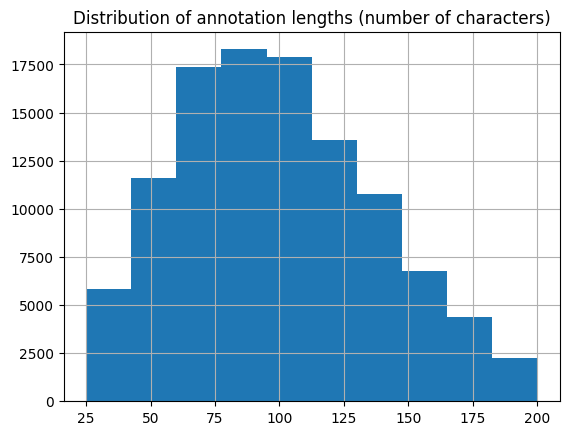

In [83]:
_=mixtec_asr_data_cleaned.annotation.apply(len).hist().set_title('Distribution of annotation lengths (number of characters)')

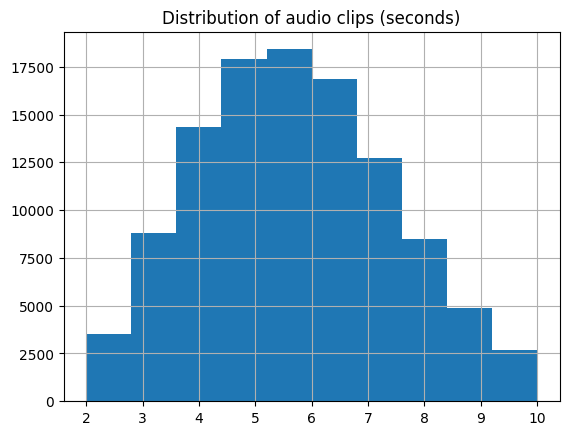

In [84]:
_=mixtec_asr_data_cleaned.duration_s.hist().set_title('Distribution of audio clips (seconds)')

## Finalise dataset

In [ ]:
# Shuffle dataset
mixtec_asr_data_cleaned = mixtec_asr_data_cleaned.sample(frac=1.0, random_state=0)

In [93]:
# Set aside first 3h of shuffled dataset as eval set
head_3h = mixtec_asr_data_cleaned.duration_s.cumsum() <= 3600 * 3

In [94]:
mixtec_eval  = mixtec_asr_data_cleaned[ head_3h ]
mixtec_train = mixtec_asr_data_cleaned[ ~head_3h ]

In [95]:
mixtec_eval

,tier,annotation,start_s,duration_s,channel,wav_file,eaf_file
339,Maximiliano Francisco González SURFACE2,i⁴jwe¹ ja¹⁴³ nĩ¹ ka⁴chi² jĩ'⁴ĩ⁴ra² ndi⁴ xa'¹a⁴...,2615.76,8.95,0,/workspace/data/Yoloxochitl/Creencias/Yolox_Cr...,data/Transcripciones-AA-Active_2025-02/Finaliz...
108,Martín Severiano Germán SURFACE1,nĩ¹nĩ'¹ĩ⁴ra² chi³ñũ³ ndi⁴ be'³e³ ta¹ kwi'⁴nã⁴ ...,682.86,4.84,0,/workspace/data/Yoloxochitl/Martin-Severiano/Y...,data/Transcripciones-AA-Active_2025-02/Not-tra...
127,Fernando Niño Leonardo SURFACE2,a¹chi¹ yu'¹u¹ ndi⁴ ñũ'⁴ũ⁴nĩ⁴² ji¹nĩ⁴² ya¹ ko⁴n...,690.87,9.29,1,/workspace/data/Yoloxochitl/Creencias/Yolox_Cr...,data/Transcripciones-AA-Active_2025-02/Finaliz...
283,RCG Corrección-Surface,ta¹ kwã'¹ã¹ tĩ³ĩ³ ji¹ndo¹ko⁴ ku⁴u² tĩ³ bu⁴ta¹ ...,1208.41,3.54,0,/workspace/data/Yoloxochitl/Esteban-Castillo-G...,data/Transcripciones-AA-Active_2025-02/Finaliz...
28,Constantino Teodoro Bautista Surface-2,nda⁴a² ba⁴² nĩ¹tỹũ³ũ⁴ ti⁴ ka¹a³ xa¹⁴ku'¹u¹ mĩ⁴...,216.34,7.86,0,/workspace/data/Yoloxochitl/ELAR-deposit/sound...,data/Transcripciones-AA-Active_2025-02/Finaliz...
...,...,...,...,...,...,...,...
411,Mario Salazar Felipe SURFACE2,yu'¹u¹ ndi⁴ ba¹⁴³ ke⁴ta³ yu'¹u¹ ñũ'³ũ⁴ yu¹⁴bi⁴...,2290.65,5.86,0,/workspace/data/Yoloxochitl/Mario-Salazar/Yolo...,data/Transcripciones-AA-Active_2025-02/Not-tra...
263,Mario Salazar Felipe SURFACE1,nĩ¹ki⁴tu³ tã³ tã³ nĩ¹ nĩ¹xa¹a¹ ba³ ta¹ bi⁴ka³ ...,1478.32,5.24,0,/workspace/data/Yoloxochitl/Mario-Salazar/Yolo...,data/Transcripciones-AA-Active_2025-02/Not-tra...
59,Constantino Teodoro Bautista SURFACE2,sa¹a³ nĩ¹i³xa³ra² tã³ ndi¹³kwe'³e²ra¹ ta¹tĩ⁴ n...,318.67,3.90,0,/workspace/data/Yoloxochitl/Constantino-Teodor...,data/Transcripciones-AA-Active_2025-02/Not-tra...
29,Victorino Ramos Rómulo SURFACE1,i³kã⁴ nda¹³ndu³kwa⁴² maña tã³ yo'⁴o⁴ tã³ kã⁴ ...,129.60,6.98,0,/workspace/data/Yoloxochitl/Victorino-Ramos/Yo...,data/Transcripciones-AA-Active_2025-02/Not-tra...


In [89]:
from lhotse import CutSet, Recording, RecordingSet, SupervisionSegment, SupervisionSet

def df2cutset(df):
    recs = RecordingSet([ Recording.from_file(w) for w in df.wav_file.unique() ])

    sups = SupervisionSet.from_segments([
        SupervisionSegment(
            id=f"{wav_file.stem}__{start_s}--{duration_s}",
            recording_id=wav_file.stem,
            start=start_s,
            duration=duration_s,
            text=annotation,
            custom={"kept_channel":channel}
        )
        for (_, tier, annotation, start_s, duration_s, channel, wav_file, eaf_file)
        in df.itertuples()
    ])
    
    cuts = CutSet.from_manifests(recordings=recs, supervisions=sups) \
        .trim_to_supervisions(keep_overlapping=False, keep_all_channels=True) \
        .filter(lambda cut: len(cut.supervisions)==1) \
        .to_eager()

    return cuts

In [96]:
train_cuts = df2cutset(mixtec_train)
train_cuts.to_jsonl("data/2025-06-20_mixtec-train.jsonl")

In [97]:
eval_cuts = df2cutset(mixtec_eval)
eval_cuts.to_jsonl("data/2025-06-20_mixtec-eval.jsonl")